In [1]:
import rdkit
from torch_geometric.datasets import MoleculeNet

# Dataset

In [2]:
data = MoleculeNet(root = ',',name='ESOL')

In [3]:
## Graph Level Prediction : Regression
print("Dataset Type : " , type(data))
print("Dataset Length : " , data.len)
print("Dataset Features : " , data.num_features)
print("Dataset Classes : " , data.num_classes)
print("Dataset Sample : " , data[0])
print("Sample Nodes :" , data[0].num_nodes)
print("Sample Edges :" , data[0].num_edges)

Dataset Type :  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset Length :  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset Features :  9
Dataset Classes :  734
Dataset Sample :  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample Nodes : 32
Sample Edges : 68


In [4]:
# edge features :
data[0].x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [5]:
## edge information (tuple 0f connected nodes)
data[5].edge_index.t()

tensor([[0, 1],
        [0, 8],
        [1, 0],
        [1, 2],
        [2, 1],
        [2, 3],
        [3, 2],
        [3, 4],
        [3, 7],
        [4, 3],
        [4, 5],
        [5, 4],
        [5, 6],
        [6, 5],
        [6, 7],
        [7, 3],
        [7, 6],
        [7, 8],
        [8, 0],
        [8, 7]])

In [6]:
## Graph output 
data[6].y

tensor([[-7.3200]])

# Implementing GNN

In [139]:
import torch
from torch.nn import Linear , Dropout
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.do1 = Dropout(p=0.5)
        # FC layer
        self.fc = Linear(embedding_size*2, 10)
        self.out = Linear(10, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply FC Layers :
        hid = self.do1(hidden)
        hid = self.fc(hid)
        hid = F.tanh(hid)
        out = self.out(hid)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (do1): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Number of parameters:  14421


In [140]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
train_loader = DataLoader(data[:int(data_size * 0.6)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
val_loader = DataLoader(data[int(data_size * 0.6):int(data_size * 0.8)], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(train_loader):
    # Enumerate over the data
    
    for batch in train_loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      loss.backward()  
      # Update using the gradients
      optimizer.step()
    return loss, embedding

def validation_loss(val_loader):
    v_loss=[]
    with torch.no_grad():
        for batch in val_loader:
            batch.to(device) 
            val_pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
            val_loss = loss_fn(val_pred, batch.y) 
            v_loss.append(val_loss)
    return  sum(v_loss)/len(v_loss)


def test_loss(test_loader):
    with torch.no_grad():
        t_loss=[]
        for batch in test_loader:
            batch.to(device) 
            test_pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
            test_loss = loss_fn(test_pred, batch.y)
            t_loss.append(test_loss)
    return sum(t_loss)/len(t_loss)


print("Starting training...")
train_losses = []
val_losses = []

for epoch in range(5000):
    train_loss, h = train(train_loader)
    train_losses.append(train_loss)
    val_loss = validation_loss(val_loader)
    val_losses.append(val_loss)
    if epoch % 10 == 0:
      print(f"Epoch {epoch} | Train Loss {train_loss} | Val Loss {val_loss}")
    if val_loss < 0.1 :
        print("Condition Satisfied!")
        print(f"Epoch {epoch} | Train Loss {train_loss} | Val Loss {val_loss}")
        break

Starting training...
Epoch 0 | Train Loss 7.160151958465576 | Val Loss 9.313027381896973
Epoch 10 | Train Loss 4.654757976531982 | Val Loss 5.780024528503418
Epoch 20 | Train Loss 3.407512664794922 | Val Loss 4.859036445617676
Epoch 30 | Train Loss 5.059898853302002 | Val Loss 4.994475364685059
Epoch 40 | Train Loss 4.2903923988342285 | Val Loss 4.999227523803711
Epoch 50 | Train Loss 5.400219440460205 | Val Loss 5.340348243713379
Epoch 60 | Train Loss 2.4192216396331787 | Val Loss 4.689610481262207
Epoch 70 | Train Loss 3.891489267349243 | Val Loss 4.85308837890625
Epoch 80 | Train Loss 4.899650573730469 | Val Loss 5.114058017730713
Epoch 90 | Train Loss 4.059142112731934 | Val Loss 4.894408702850342
Epoch 100 | Train Loss 5.429331302642822 | Val Loss 4.972578048706055
Epoch 110 | Train Loss 3.3876190185546875 | Val Loss 4.687424659729004
Epoch 120 | Train Loss 4.014639854431152 | Val Loss 4.8972954750061035
Epoch 130 | Train Loss 2.2254996299743652 | Val Loss 4.753316879272461
Epoch 

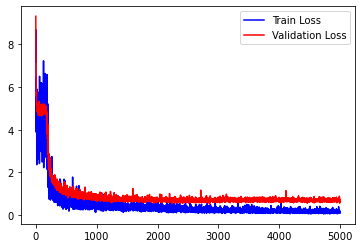

In [141]:
# Visualize learning (training loss)
import matplotlib.pyplot as plt

train_losses_float = [float(loss.cpu().detach().numpy()) for loss in train_losses] 

val_losses_float = [float(loss.cpu().detach().numpy()) for loss in val_losses] 

plt.plot(train_losses_float , color = 'blue')
plt.plot(val_losses_float , color = 'red')
plt.legend(['Train Loss' , 'Validation Loss'])
plt.show()

In [142]:
import pandas as pd 
# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
print(df)
print("***************")
print(f"Test Loss = {test_loss(test_loader)}")

    y_real    y_pred
0    0.150 -0.626235
1   -3.931 -5.215529
2   -2.349 -2.020530
3   -1.620 -2.418957
4    0.940 -1.564416
..     ...       ...
59  -2.090 -2.374141
60  -3.790 -3.793498
61  -1.790 -2.313623
62  -4.240 -6.966203
63  -0.800 -0.919504

[64 rows x 2 columns]
***************
Test Loss = 0.7585558295249939


<AxesSubplot:xlabel='y_real', ylabel='y_pred'>

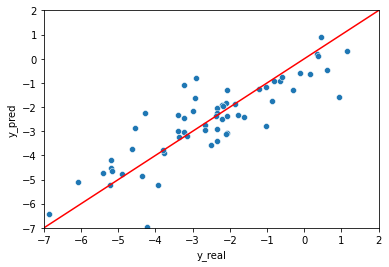

In [143]:
import numpy as np
x= np.linspace(-7,2)
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.plot(x,x,color='r')
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt